In [1]:
cd ../src/models

/Users/adamnavarroliriano/Documents/Personal/Code/forecast/forecast-sktime/src/models


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils.config import get_model_params, get_env_params

In [4]:

import pandas as pd
import numpy as np 
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import ARIMA, AutoARIMA

# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting  import plot_correlations
from sktime.utils.plotting import plot_series
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro 
from sktime.forecasting.compose import make_reduction

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV, ForecastingGridSearchCV

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

from utils.config import get_model_params, get_env_params
from utils.data import load_data, split_timeseries
from sktime.forecasting.model_evaluation import evaluate
from utils.cross_val import create_cv_splitter
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.exponent import ExponentTransformer
from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.impute import Imputer

from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteError, MedianAbsolutePercentageError
from plotnine import *

## Setup

In [5]:
# Read data
data = load_data('main')
train, test = split_timeseries(data, 12)
env_params = get_env_params("main")

# Split
fh = env_params.fh
y = train["y"].reset_index(drop=True)
y_test = test['y'].reset_index(drop=True)
cv = create_cv_splitter(
    strategy=env_params.cross_val.strategy,
    forecasting_horizon=fh,
    **env_params.cross_val.args
)


## Baseline

### Naive approaches

In [6]:
mape = MeanAbsolutePercentageError()
mae = MeanAbsoluteError()
mdape = MedianAbsolutePercentageError()
scoring = [mape, mae, mdape]
test_scores_funcs = ['test_MeanAbsolutePercentageError', 'test_MeanAbsoluteError', 'test_MedianAbsolutePercentageError']

strategies = ['last', 'mean', 'drift']
periodicities = [1, 6, 12]

In [7]:
strategies = ['last', 'mean', 'drift']
periodicities = [1, 6, 12]

naive_forecaster = pd.DataFrame()

for strategy in  strategies:
    for periodicity in periodicities:
        forecaster = NaiveForecaster(strategy=strategy, sp=periodicity)
        forecaster.fit(y, fh=fh)
        df = evaluate(forecaster=forecaster, cv=cv, y=y, scoring=scoring)
        naive_forecaster = pd.concat([naive_forecaster, df.assign(strategy=strategy, sp=periodicity)], ignore_index=True)


In [8]:
(naive_forecaster
 .groupby(['strategy', 'sp'])[test_scores_funcs]
 .agg([np.mean, np.min, np.median]))

test_MeanAbsolutePercentageError                      \
                                        mean      amin    median   
strategy sp                                                        
drift    1                          0.327101  0.327101  0.327101   
         6                          0.327101  0.327101  0.327101   
         12                         0.327101  0.327101  0.327101   
last     1                          0.317740  0.317740  0.317740   
         6                          0.188652  0.188652  0.188652   
         12                         0.164633  0.164633  0.164633   
mean     1                          0.188579  0.188579  0.188579   
         6                          0.167808  0.167808  0.167808   
         12                         0.164550  0.164550  0.164550   

            test_MeanAbsoluteError                      \
                              mean      amin    median   
strategy sp                                              
drift    1                0.956065  0.956065  0.956065   
         6                0.956065  0.956065  0.956065   
         12               0.956065  0.956065  0.956065   
last     1                0.931910  0.931910  0.931910   
         6                0.507588  0.507588  0.507588   
         12               0.407738  0.407738  0.407738   
mean     1                0.500513  0.500513  0.500513   
         6                0.456426  0.456426  0.456426   
         12               0.456616  0.456616  0.456616   

            test_MedianAbsolutePercentageError                      
                                          mean      amin    median  
strategy sp                                                         
drift    1                            0.331923  0.331923  0.331923  
         6                            0.331923  0.331923  0.331923  
         12                           0.331923  0.331923  0.331923  
last     1                            0.320944  0.320944  0.320944  
         6                            0.162851  0.162851  0.162851  
         12                           0.123582  0.123582  0.123582  
mean     1                            0.177874  0.177874  0.177874  
         6                            0.136283  0.136283  0.136283  
         12                           0.154410  0.154410  0.154410

We will focus on minimizing the MAE

In [9]:
naive_pipeline = NaiveForecaster(strategy='last', sp=1)
naive_last_pipeline = NaiveForecaster(strategy='last', sp=12)

### Baseline + transformations

In [10]:
log_naive_forecaster = pd.DataFrame()
for strategy in strategies:
    for periodicity in periodicities:
        forecaster =  LogTransformer() * NaiveForecaster(strategy=strategy, sp=periodicity)
        forecaster.fit(y, fh=np.arange(1, 13))
        df = evaluate(forecaster=forecaster, cv=cv, y=y, scoring=scoring)
        log_naive_forecaster = pd.concat([log_naive_forecaster, df.assign(strategy=strategy, sp=periodicity)], ignore_index=True)

In [11]:
log_naive_forecaster.groupby(['strategy', 'sp'])[test_scores_funcs].agg([np.mean, np.min, np.median])

test_MeanAbsolutePercentageError                      \
                                        mean      amin    median   
strategy sp                                                        
drift    1                          0.326375  0.326375  0.326375   
         6                          0.326375  0.326375  0.326375   
         12                         0.326375  0.326375  0.326375   
last     1                          0.317740  0.317740  0.317740   
         6                          0.188652  0.188652  0.188652   
         12                         0.164633  0.164633  0.164633   
mean     1                          0.192578  0.192578  0.192578   
         6                          0.173288  0.173288  0.173288   
         12                         0.167780  0.167780  0.167780   

            test_MeanAbsoluteError                      \
                              mean      amin    median   
strategy sp                                              
drift    1                0.954319  0.954319  0.954319   
         6                0.954319  0.954319  0.954319   
         12               0.954319  0.954319  0.954319   
last     1                0.931910  0.931910  0.931910   
         6                0.507588  0.507588  0.507588   
         12               0.407738  0.407738  0.407738   
mean     1                0.523043  0.523043  0.523043   
         6                0.479229  0.479229  0.479229   
         12               0.472753  0.472753  0.472753   

            test_MedianAbsolutePercentageError                      
                                          mean      amin    median  
strategy sp                                                         
drift    1                            0.331213  0.331213  0.331213  
         6                            0.331213  0.331213  0.331213  
         12                           0.331213  0.331213  0.331213  
last     1                            0.320944  0.320944  0.320944  
         6                            0.162851  0.162851  0.162851  
         12                           0.123582  0.123582  0.123582  
mean     1                            0.195784  0.195784  0.195784  
         6                            0.165502  0.165502  0.165502  
         12                           0.142275  0.142275  0.142275

 Based on evaluation results we pick last 12 months. As `log` is an increasing function, we don't need to create another pipeline

In [12]:
sqrt_naive_forecaster = pd.DataFrame()
for strategy in strategies:
    for periodicity in periodicities:
        forecaster =  ExponentTransformer(power=0.5) * NaiveForecaster(strategy=strategy, sp=periodicity)
        forecaster.fit(y, fh=np.arange(1, 13))
        df = evaluate(forecaster=forecaster, cv=cv, y=y, scoring=scoring)
        sqrt_naive_forecaster = pd.concat([sqrt_naive_forecaster, df.assign(strategy=strategy, sp=periodicity)], ignore_index=True)

In [13]:
sqrt_naive_forecaster.groupby(['strategy', 'sp'])[test_scores_funcs].agg([np.mean, np.min, np.median])

test_MeanAbsolutePercentageError                      \
                                        mean      amin    median   
strategy sp                                                        
drift    1                          0.326729  0.326729  0.326729   
         6                          0.326729  0.326729  0.326729   
         12                         0.326729  0.326729  0.326729   
last     1                          0.317740  0.317740  0.317740   
         6                          0.188652  0.188652  0.188652   
         12                         0.164633  0.164633  0.164633   
mean     1                          0.190583  0.190583  0.190583   
         6                          0.170505  0.170505  0.170505   
         12                         0.164606  0.164606  0.164606   

            test_MeanAbsoluteError                      \
                              mean      amin    median   
strategy sp                                              
drift    1                0.955170  0.955170  0.955170   
         6                0.955170  0.955170  0.955170   
         12               0.955170  0.955170  0.955170   
last     1                0.931910  0.931910  0.931910   
         6                0.507588  0.507588  0.507588   
         12               0.407738  0.407738  0.407738   
mean     1                0.511805  0.511805  0.511805   
         6                0.467716  0.467716  0.467716   
         12               0.460787  0.460787  0.460787   

            test_MedianAbsolutePercentageError                      
                                          mean      amin    median  
strategy sp                                                         
drift    1                            0.331559  0.331559  0.331559  
         6                            0.331559  0.331559  0.331559  
         12                           0.331559  0.331559  0.331559  
last     1                            0.320944  0.320944  0.320944  
         6                            0.162851  0.162851  0.162851  
         12                           0.123582  0.123582  0.123582  
mean     1                            0.184386  0.184386  0.184386  
         6                            0.150727  0.150727  0.150727  
         12                           0.148320  0.148320  0.148320

 Based on evaluation results we pick last 12 months. As `sqrt` is an increasing function, we don't need to create another pipeline

## ARIMA

Based on EDA notebook, we propose two candidates
* ARIMA with `log` transformation to the series
* ARIMA with `sqrt` transformation to the series

We'll apply Box-Jenkins methodology to fit both ARIMAs

### log model

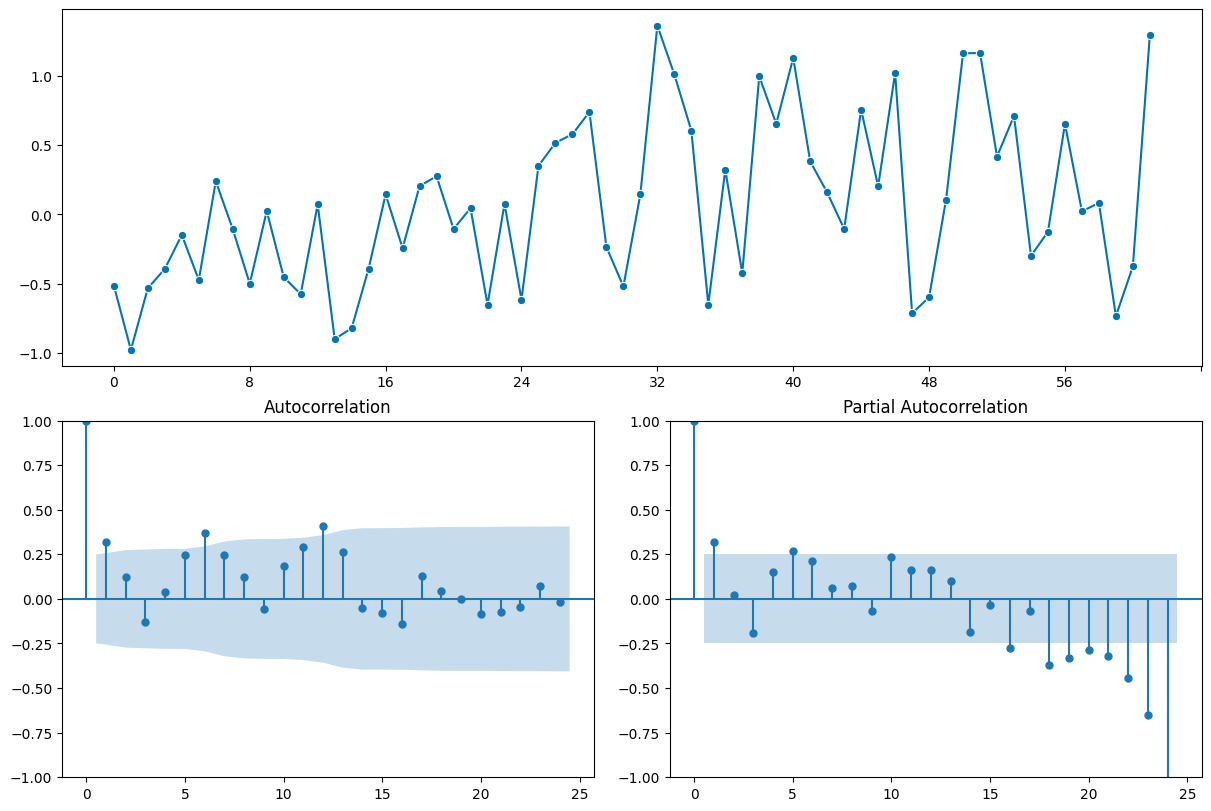

,lb_stat,lb_pvalue
1,6.486377,0.010870
6,20.108159,0.002649
12,39.409695,0.000090
19,45.043469,0.000676
24,45.883421,0.004572
32,66.634477,0.000314
48,89.948867,0.000233
56,98.391170,0.000403
61,107.637320,0.000215


In [14]:
log_transformation = LogTransformer()

pipe = TransformedTargetForecaster([
    log_transformation,
    ARIMA(order=(0,0,0), seasonal_order=(0,0,0, 12), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 19, 24, 32, 48, 56, 61], return_df=True)

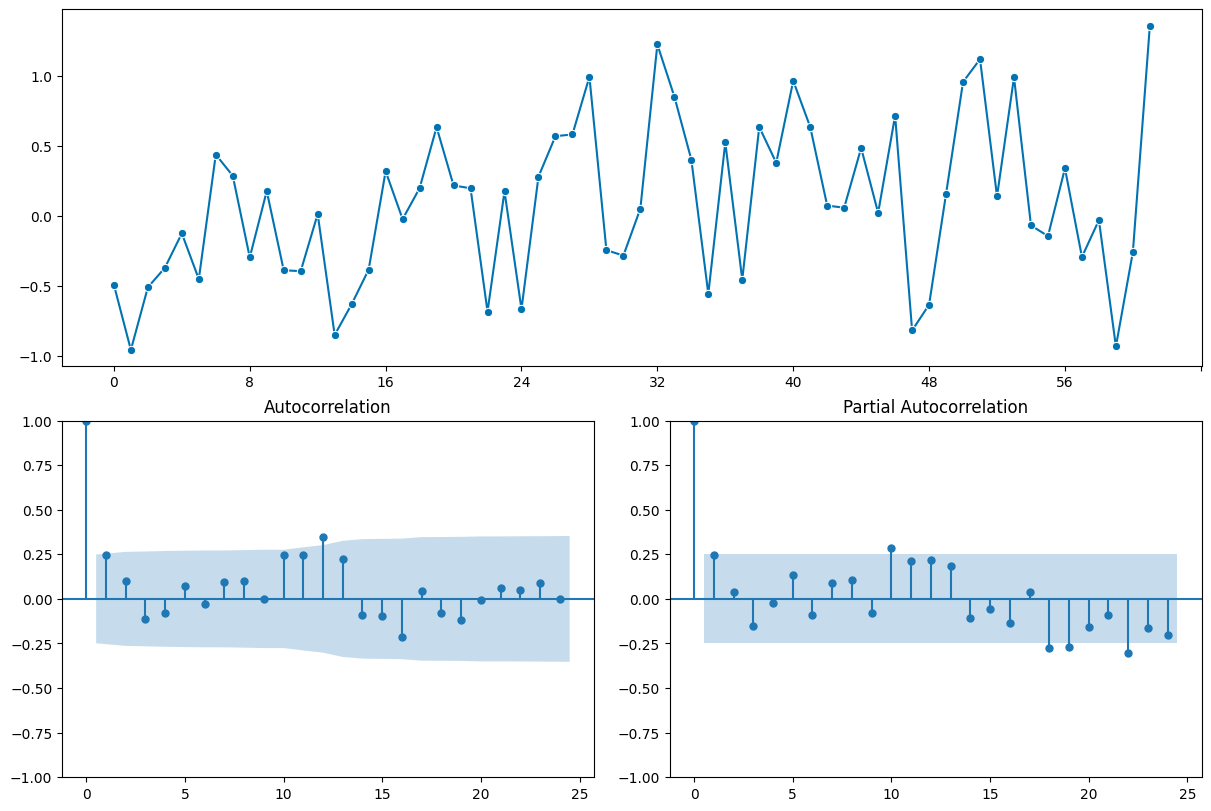

,lb_stat,lb_pvalue
1,3.818103,0.050702
6,5.896466,0.434888
12,19.622790,0.074566
18,25.534744,0.110881
24,26.718081,0.317765
32,42.684322,0.098207
48,67.840440,0.031126
56,80.389048,0.018014
61,95.190521,0.003341


In [15]:
# We add seasonal AR component with periodicity 6
pipe = TransformedTargetForecaster([
    log_transformation,
    ARIMA(order=(0,0,0), seasonal_order=(1,0,0, 6), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 18, 24, 32, 48, 56, 61], return_df=True)

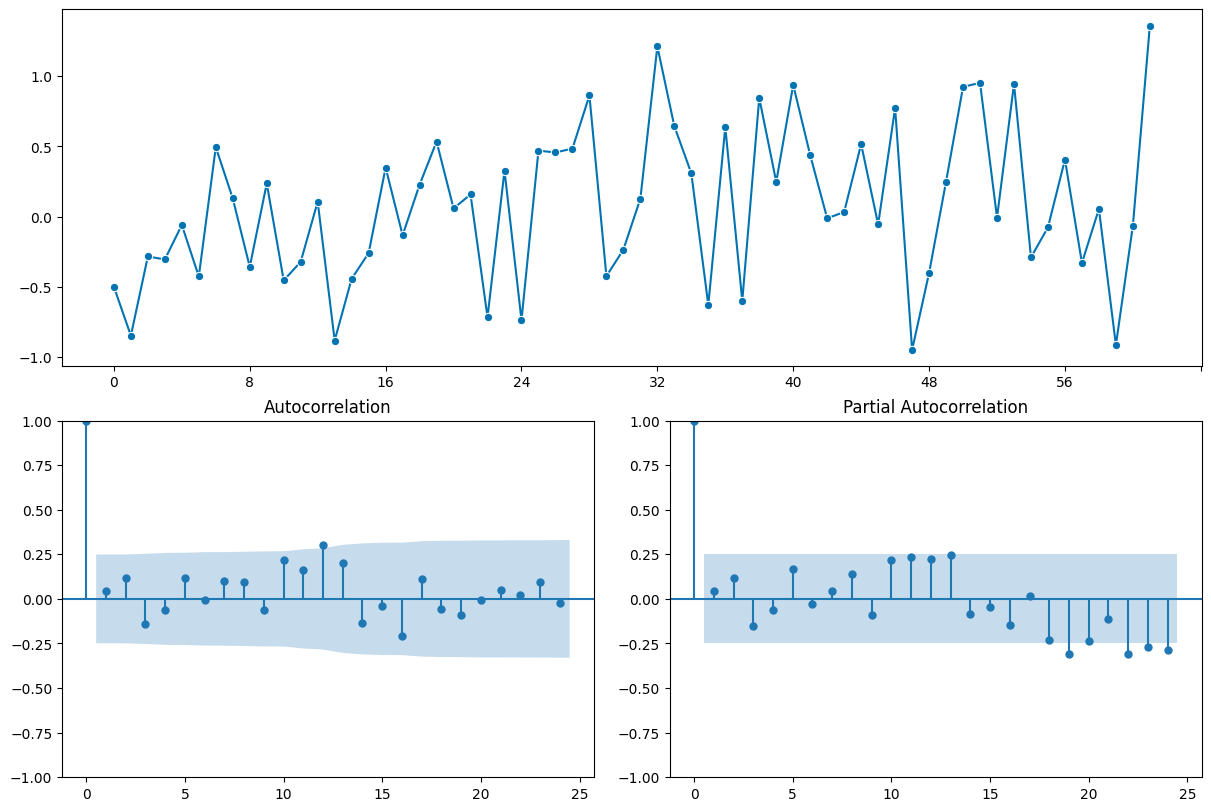

,lb_stat,lb_pvalue
1,0.119292,0.729804
6,3.291253,0.771503
12,13.158130,0.357653
18,18.984875,0.392755
24,19.860286,0.704693
32,32.333661,0.450283
48,50.508629,0.374664
56,59.152636,0.361205
61,73.614213,0.129015


In [16]:
# We add MA component of 1
pipe = TransformedTargetForecaster([
    log_transformation,
    ARIMA(order=(0,0,1), seasonal_order=(1,0,0, 6), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 18, 24, 32, 48, 56, 61], return_df=True)

There is no evidence for significant autocorrelation in the residuals. We also plot the residuals to check that they're centered at zero

<Axes: ylabel='Count'>

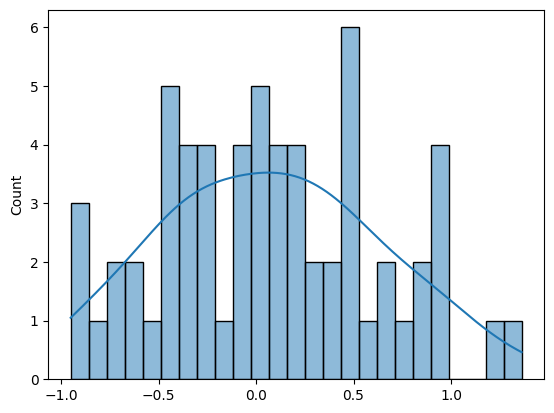

In [17]:
sns.histplot(residuals, bins=25, kde=True)

Finally we evaluate with cross validation

In [18]:
cv_pipe_log = evaluate(forecaster=pipe, cv=cv, y=y, scoring=scoring)
cv_pipe_log

,test_MeanAbsolutePercentageError,test_MeanAbsoluteError,test_MedianAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.165344,0.457008,0.14872,0.158043,0.013297,48,47


In [19]:
pipe.get_fitted_params()['ARIMA'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   62
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 6)   Log Likelihood                   4.771
Date:                            Tue, 14 May 2024   AIC                             -1.541
Time:                                    00:54:06   BIC                              6.967
Sample:                                         0   HQIC                             1.799
                                             - 62                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6363      0.127      4.992      0.000       0.387       0.886
ma.L1          0.2221      0.143      1.552      0.121      -0.058       0.503
ar.S.L6        0.2773      0.139      1.997      0.046       0.005       0.549
sigma2         0.0498      0.011      4.425      0.000       0.028       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 1.74
Prob(Q):                              0.79   Prob(JB):                         0.42
Heteroskedasticity (H):               1.35   Skew:                            -0.25
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**The residuals of the fitted models seem to be normally distributed (Jarque-Bera), not autocorrelated and the variance doesn't seem to present heteroskedasticity**

In [20]:
arima_pipe_log = TransformedTargetForecaster([
    log_transformation,
    ARIMA(order=(0,0,1), seasonal_order=(1,0,0, 6), maxiter=1000),
])

### Sqrt transform

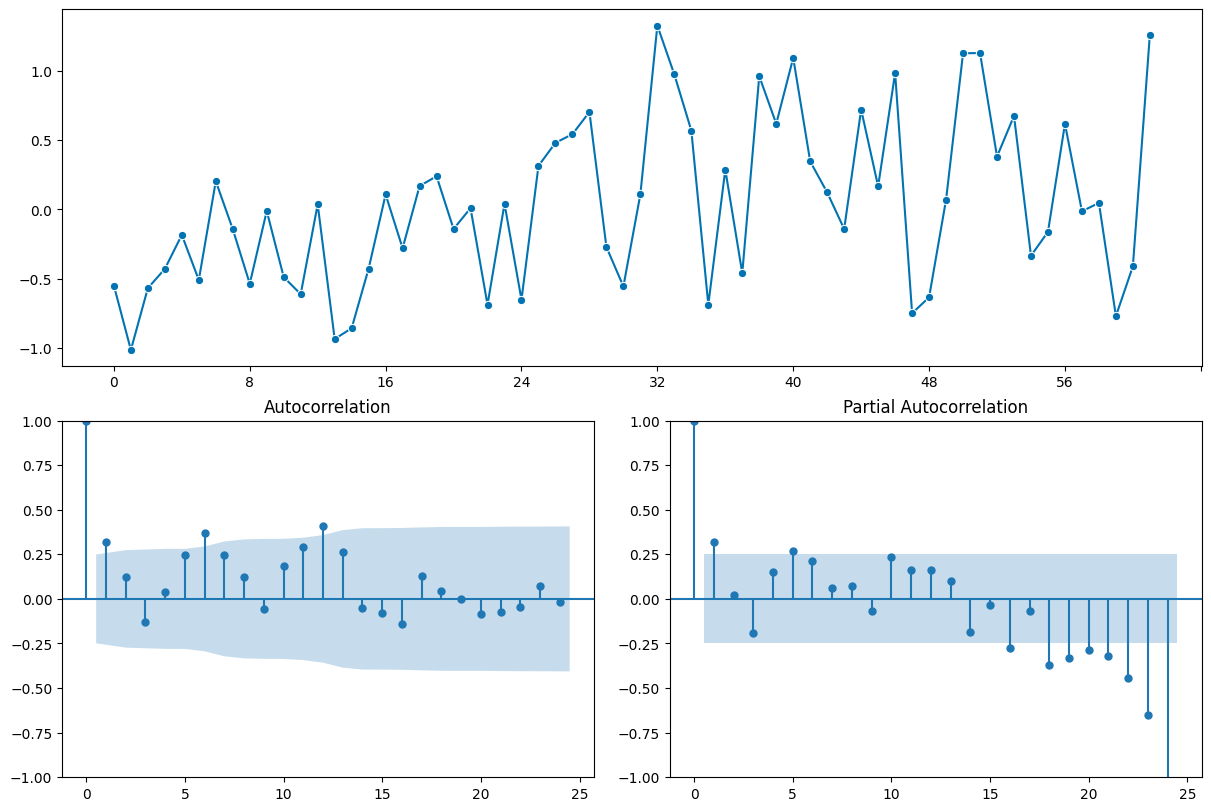

,lb_stat,lb_pvalue
1,6.486377,0.010870
6,20.108159,0.002649
12,39.409695,0.000090
19,45.043469,0.000676
24,45.883421,0.004572
32,66.634477,0.000314
48,89.948867,0.000233
56,98.391170,0.000403
61,107.637320,0.000215


In [21]:
transformation = ExponentTransformer(power=0.5)

pipe = TransformedTargetForecaster([
    transformation,
    ARIMA(order=(0,0,0), seasonal_order=(0,0,0, 12), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 19, 24, 32, 48, 56, 61], return_df=True)

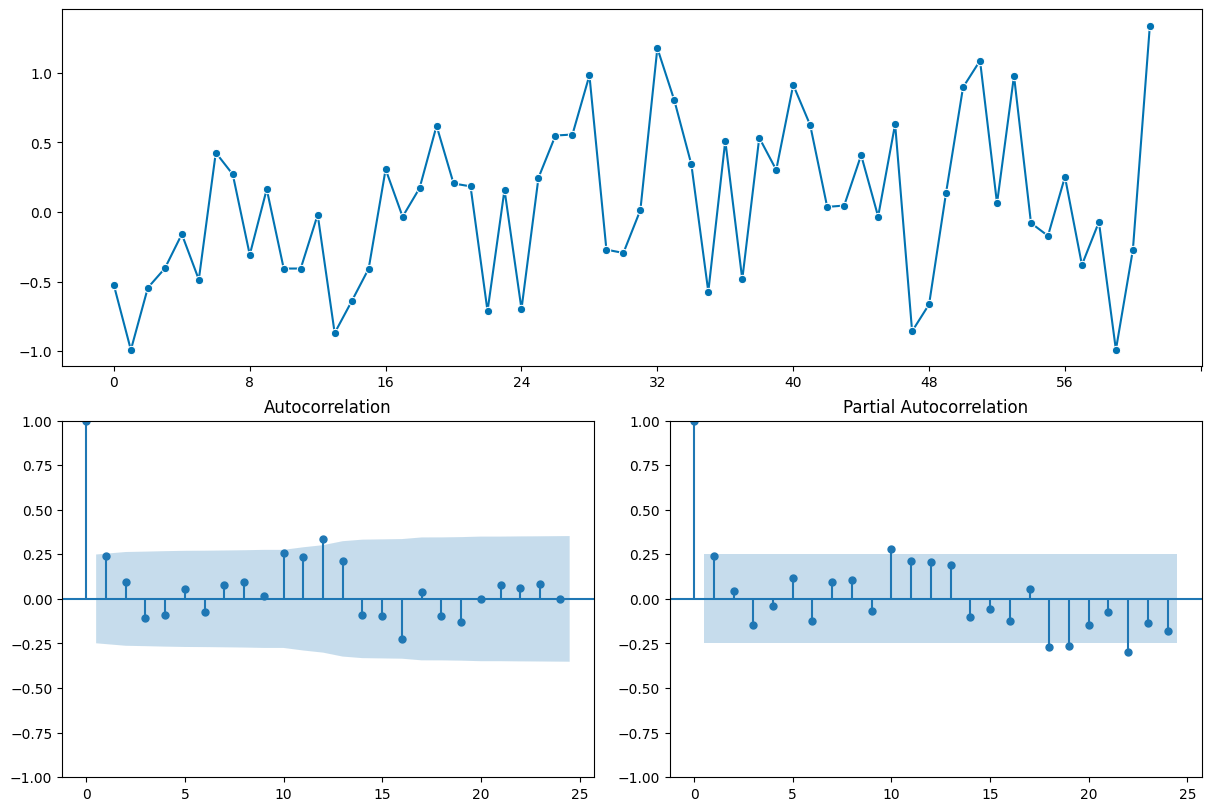

,lb_stat,lb_pvalue
1,3.621624,0.057033
6,5.852296,0.439938
12,19.002072,0.088478
19,25.774981,0.136582
24,26.456562,0.330413
32,42.247640,0.106269
48,68.837800,0.025881
56,82.385294,0.012415


In [22]:
transformation = ExponentTransformer(power=0.5)

pipe = TransformedTargetForecaster([
    transformation,
    ARIMA(order=(0,0,0), seasonal_order=(1,0,0, 6), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 19, 24, 32, 48, 56], return_df=True)

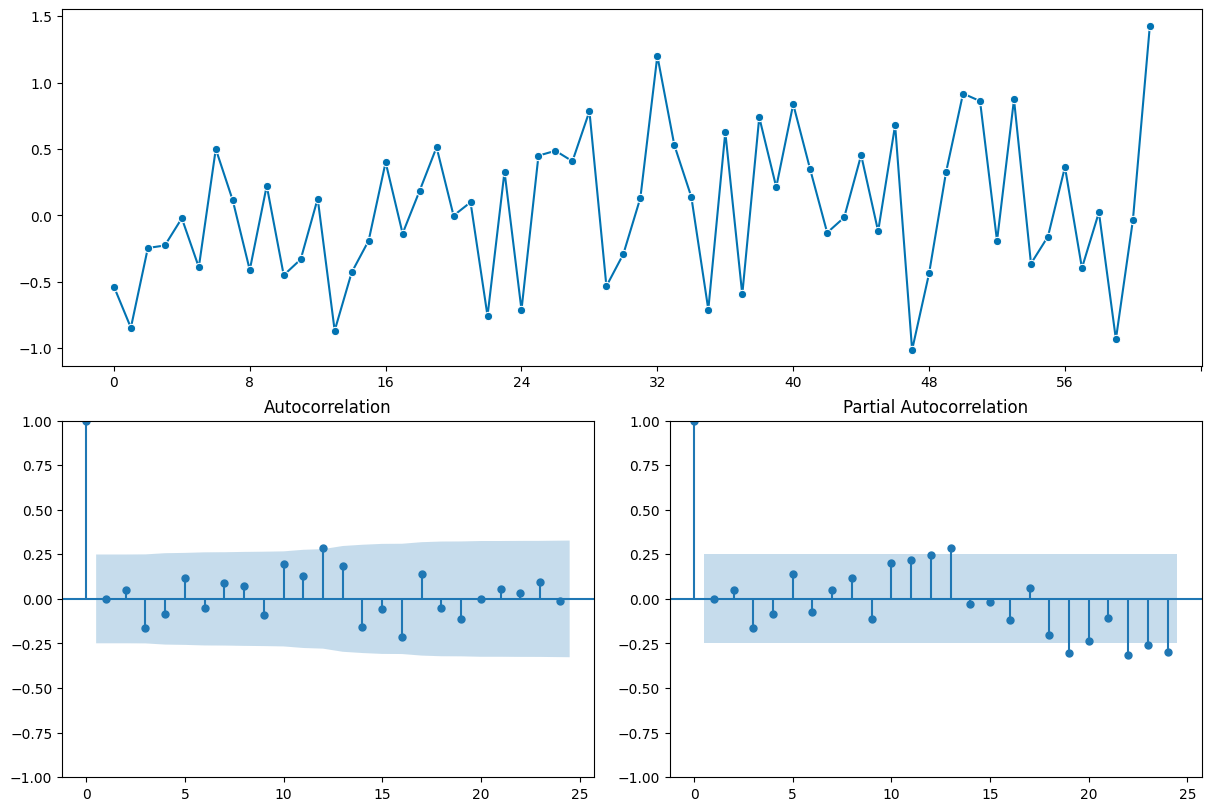

,lb_stat,lb_pvalue
1,0.000060,0.993836
6,3.150088,0.789787
12,11.427980,0.492640
19,18.195186,0.509438
24,18.749769,0.765199
32,30.845039,0.524893
48,48.259032,0.462369
56,56.462000,0.457577
61,73.960841,0.123288


In [23]:
transformation = ExponentTransformer(power=0.5)

pipe = TransformedTargetForecaster([
    transformation,
    ARIMA(order=(1,0,1), seasonal_order=(1,0,0, 6), maxiter=1000),
])
    
pipe.fit(y, fh=np.arange(1,13))
residuals=pipe.predict_residuals()
plot_correlations(residuals)
plt.show()
sm.stats.acorr_ljungbox(residuals, lags=[1, 6, 12, 19, 24, 32, 48, 56, 61], return_df=True)

<Axes: ylabel='Count'>

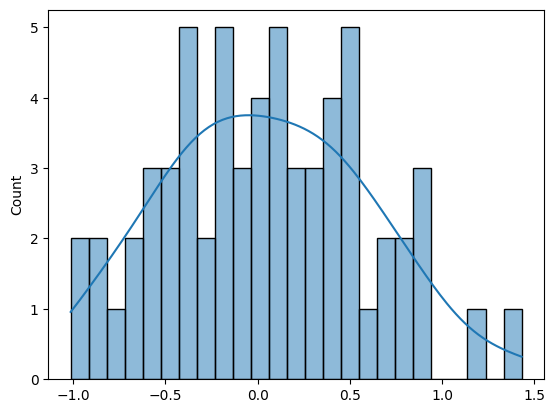

In [24]:
sns.histplot(residuals, bins=25, kde=True)

In [25]:
cv_pipe_sqrt = evaluate(forecaster=pipe, cv=cv, y=y, scoring=scoring)
cv_pipe_sqrt

,test_MeanAbsolutePercentageError,test_MeanAbsoluteError,test_MedianAbsolutePercentageError,fit_time,pred_time,len_train_window,cutoff
0,0.166951,0.460874,0.156597,0.144051,0.010656,48,47


In [26]:
arima_model = pipe.get_fitted_params()['ARIMA']

In [27]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   62
Model:             SARIMAX(1, 0, 1)x(1, 0, [], 6)   Log Likelihood                  21.014
Date:                            Tue, 14 May 2024   AIC                            -32.028
Time:                                    00:54:09   BIC                            -21.392
Sample:                                         0   HQIC                           -27.852
                                             - 62                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7048      0.564      1.249      0.212      -0.401       1.810
ar.L1          0.3566      0.463      0.771      0.441      -0.550       1.263
ma.L1         -0.0889      0.493     -0.180      0.857      -1.055       0.877
ar.S.L6        0.2998      0.145      2.074      0.038       0.016       0.583
sigma2         0.0294      0.006      4.592      0.000       0.017       0.042
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.95   Prob(JB):                         0.66
Heteroskedasticity (H):               1.80   Skew:                            -0.02
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
arima_pipe_sqrt = TransformedTargetForecaster([
    ExponentTransformer(0.5),
    ARIMA(order=(1,0,1), seasonal_order=(1,0,0, 6), maxiter=1000),
])

## TreeBased

In [29]:
def find_gridsearch_params(y, forecaster, param_grid, fh, cv, **kwargs):
    gridsearch_cv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid, **kwargs)
    gridsearch_cv.fit(y, fh=fh)
    return gridsearch_cv

def create_reduction_forecaster(estimator, transform = None):
    if transform is None:
        return  make_reduction(estimator)
    return transform * make_reduction(estimator)
    

In [30]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)
xgboost = XGBRegressor(random_state=0, n_jobs=-1)

rf_log = create_reduction_forecaster(rf, LogTransformer())

In [31]:
tree_params = {"window_length": [1, 6, 12,], 
              "n_estimators": [100, 250, 500, 750, 1000], 
              "max_depth": [1, 2]
             }

tree_scorer = MeanAbsoluteError()

regressors = {
    'rf': rf, 
    'xgboost': xgboost
}

transforms = {'log': LogTransformer(), 'sqrt': ExponentTransformer(0.5)}

tree_forecasters = {}

for estimator in regressors.keys():
    for transform in transforms.keys():
        model = create_reduction_forecaster(regressors[estimator], transforms[transform])
        tree_forecasters[f"{estimator}_{transform}"] = find_gridsearch_params(y=y, 
                                                                              forecaster=model, 
                                                                              param_grid=tree_params, 
                                                                              fh=fh, 
                                                                              cv=cv,
                                                                              n_jobs=8, 
                                                                              scoring=tree_scorer
                                                                             )
                                                                            
        print(f"{estimator} + {transform} done!")
        

rf + log done!
rf + sqrt done!
xgboost + log done!
xgboost + sqrt done!


In [32]:
tree_results = pd.DataFrame()
for key, result in tree_forecasters.items():
    tree_results = pd.concat([tree_results, 
                              result.cv_results_.sort_values(by='mean_test_MeanAbsoluteError').assign(model=key)],
                            ignore_index=True)

In [33]:
tree_results.groupby(['model'])['mean_test_MeanAbsoluteError'].agg([np.mean, np.min, np.median]).reset_index()

,model,mean,amin,median
0,rf_log,0.493515,0.423947,0.471352
1,rf_sqrt,0.493803,0.433819,0.475316
2,xgboost_log,0.587212,0.435420,0.559952
3,xgboost_sqrt,0.584030,0.466173,0.571644


In [34]:
cv_results = pd.DataFrame()
for key, forecaster in tree_forecasters.items():
    estimator = forecaster.best_forecaster_
    df = evaluate(forecaster=estimator, y=y, cv=cv, scoring=scoring)
    cv_results = pd.concat([cv_results, df.assign(model=key)], ignore_index=True)


In [35]:
cv_results.groupby('model')[test_scores_funcs].agg([np.mean, np.min, np.median])

test_MeanAbsolutePercentageError                      \
                                         mean      amin    median   
model                                                               
rf_log                               0.163000  0.163000  0.163000   
rf_sqrt                              0.167862  0.167862  0.167862   
xgboost_log                          0.171559  0.171559  0.171559   
xgboost_sqrt                         0.181952  0.181952  0.181952   

             test_MeanAbsoluteError                      \
                               mean      amin    median   
model                                                     
rf_log                     0.423947  0.423947  0.423947   
rf_sqrt                    0.433819  0.433819  0.433819   
xgboost_log                0.435420  0.435420  0.435420   
xgboost_sqrt               0.466173  0.466173  0.466173   

             test_MedianAbsolutePercentageError                      
                                           mean      amin    median  
model                                                                
rf_log                                 0.117189  0.117189  0.117189  
rf_sqrt                                0.118421  0.118421  0.118421  
xgboost_log                            0.188648  0.188648  0.188648  
xgboost_sqrt                           0.197767  0.197767  0.197767

By all metrics, the log models seem to be doing best

In [36]:
tree_pipelines = {}

for key, forecaster in tree_forecasters.items():
    tree_pipelines[f"{key}_pipeline"] = forecaster.best_forecaster_

## Check performance on test set

In [37]:
all_models = {
    'naive_pipeline': naive_pipeline, 
    'naive_last_pipeline': naive_last_pipeline, 
    'arima_log_pipeline': arima_pipe_log, 
    'arima_sqrt_pipeline': arima_pipe_sqrt,
    **tree_pipelines
}


# Fit all models
for _, model in all_models.items():
    model.fit(y, fh=fh)
    

In [38]:
mae = MeanAbsoluteError()
mape = MeanAbsolutePercentageError()
mdape = MedianAbsolutePercentageError()

In [39]:
# Compute prediction and metrics for all models 
preds = {}
metrics = []
for model_name, model in all_models.items():
    model_prediction = model.predict(fh)
    preds[model_name] = model_prediction

    # Compute metrics
    metrics.append((model_name, mae(y_test, model_prediction), mape(y_test, model_prediction), mdape(y_test, model_prediction)))

metrics_df = pd.DataFrame(metrics, columns = ('model_name', 'mae', 'mape', 'mdape'))

In [40]:
metrics_df.sort_values(by='mape')

,model_name,mae,mape,mdape
2,arima_log_pipeline,0.508965,0.225031,0.174407
6,xgboost_log_pipeline,0.519415,0.240093,0.170624
4,rf_log_pipeline,0.511957,0.240560,0.186292
3,arima_sqrt_pipeline,0.551575,0.248205,0.196768
5,rf_sqrt_pipeline,0.530589,0.250839,0.203113
7,xgboost_sqrt_pipeline,0.566025,0.264793,0.183940
1,naive_last_pipeline,0.681329,0.331476,0.251494
0,naive_pipeline,1.377942,0.657178,0.686887


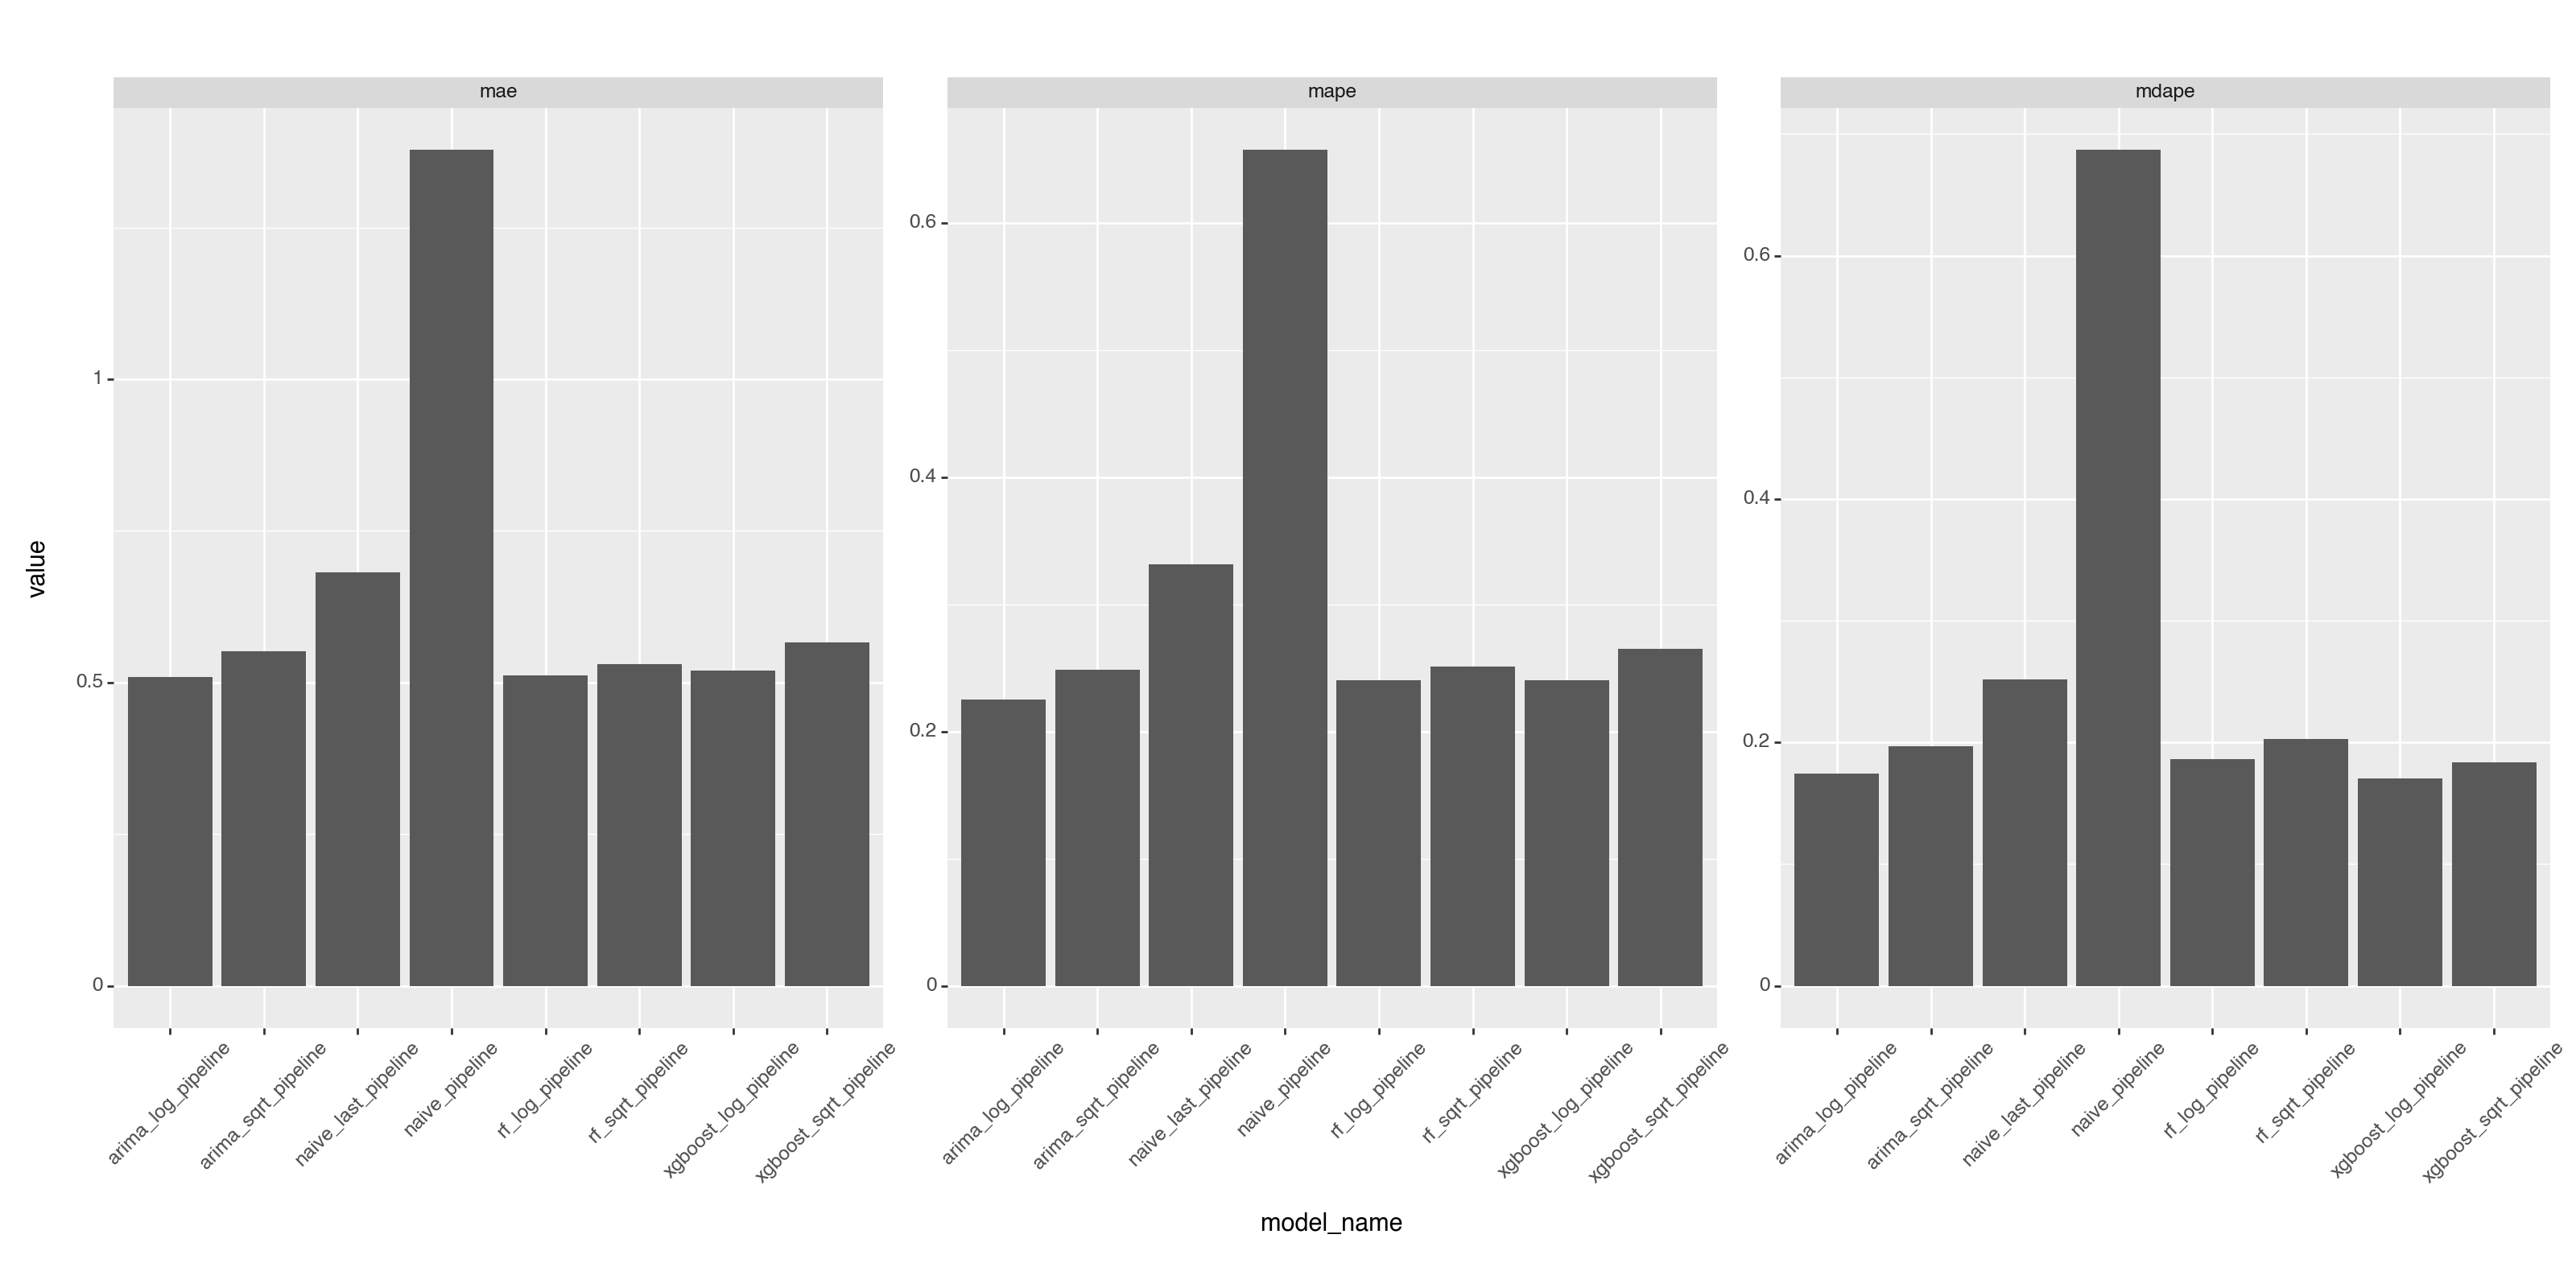

<Figure Size: (1600 x 800)>

In [41]:
(
ggplot(metrics_df.melt(id_vars='model_name', var_name = 'metric'), aes(x='model_name', y='value')) +
    geom_bar(stat='identity') +
    facet_wrap('~metric', scales='free_y', ncol=3) +
    theme(figure_size=(16, 8)) +
    theme(axis_text_x=element_text(angle=45)) 
    
    
)

Looking at the candidates, the best performing models are the Arima + Log transformation, the XGBoost + Log transformation and the RandomForest + Log transformation.

### Plot predicted values of some models

In [42]:
real_values = y_test.copy()
real_values.index = np.arange(y.index.max() + 1, y.index.max() + 13, 1)

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

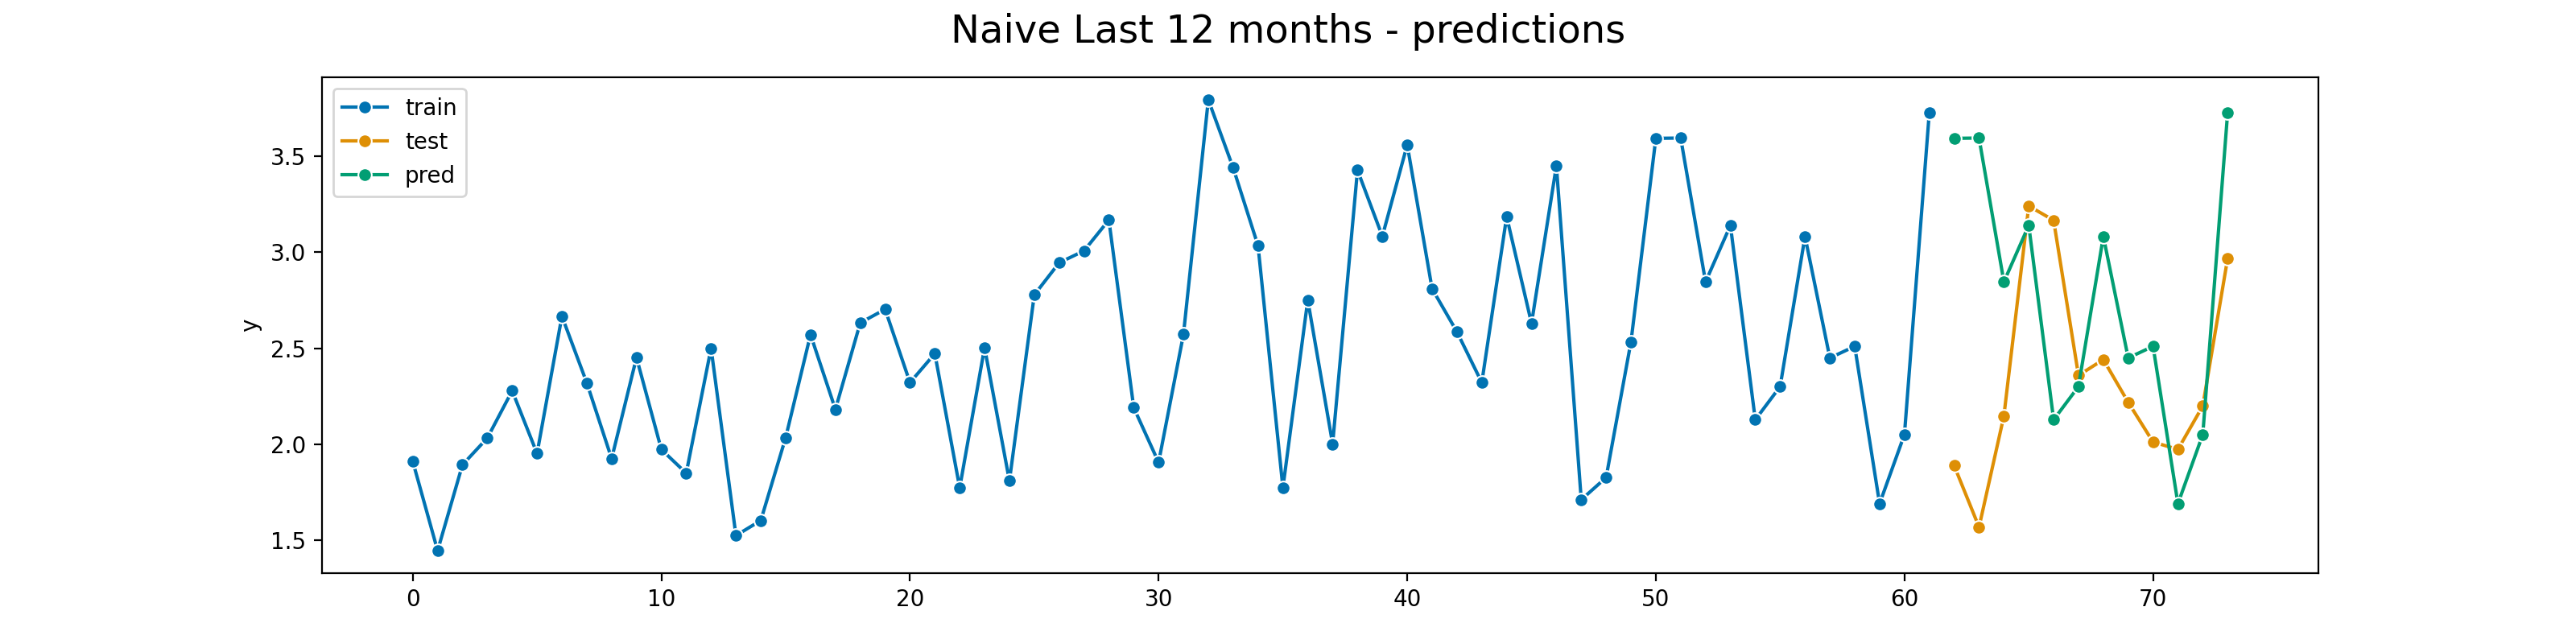

In [43]:
plot_series(y, real_values, all_models['naive_last_pipeline'].predict(fh),  labels=['train', 'test', 'pred'], title='Naive Last 12 months - predictions')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

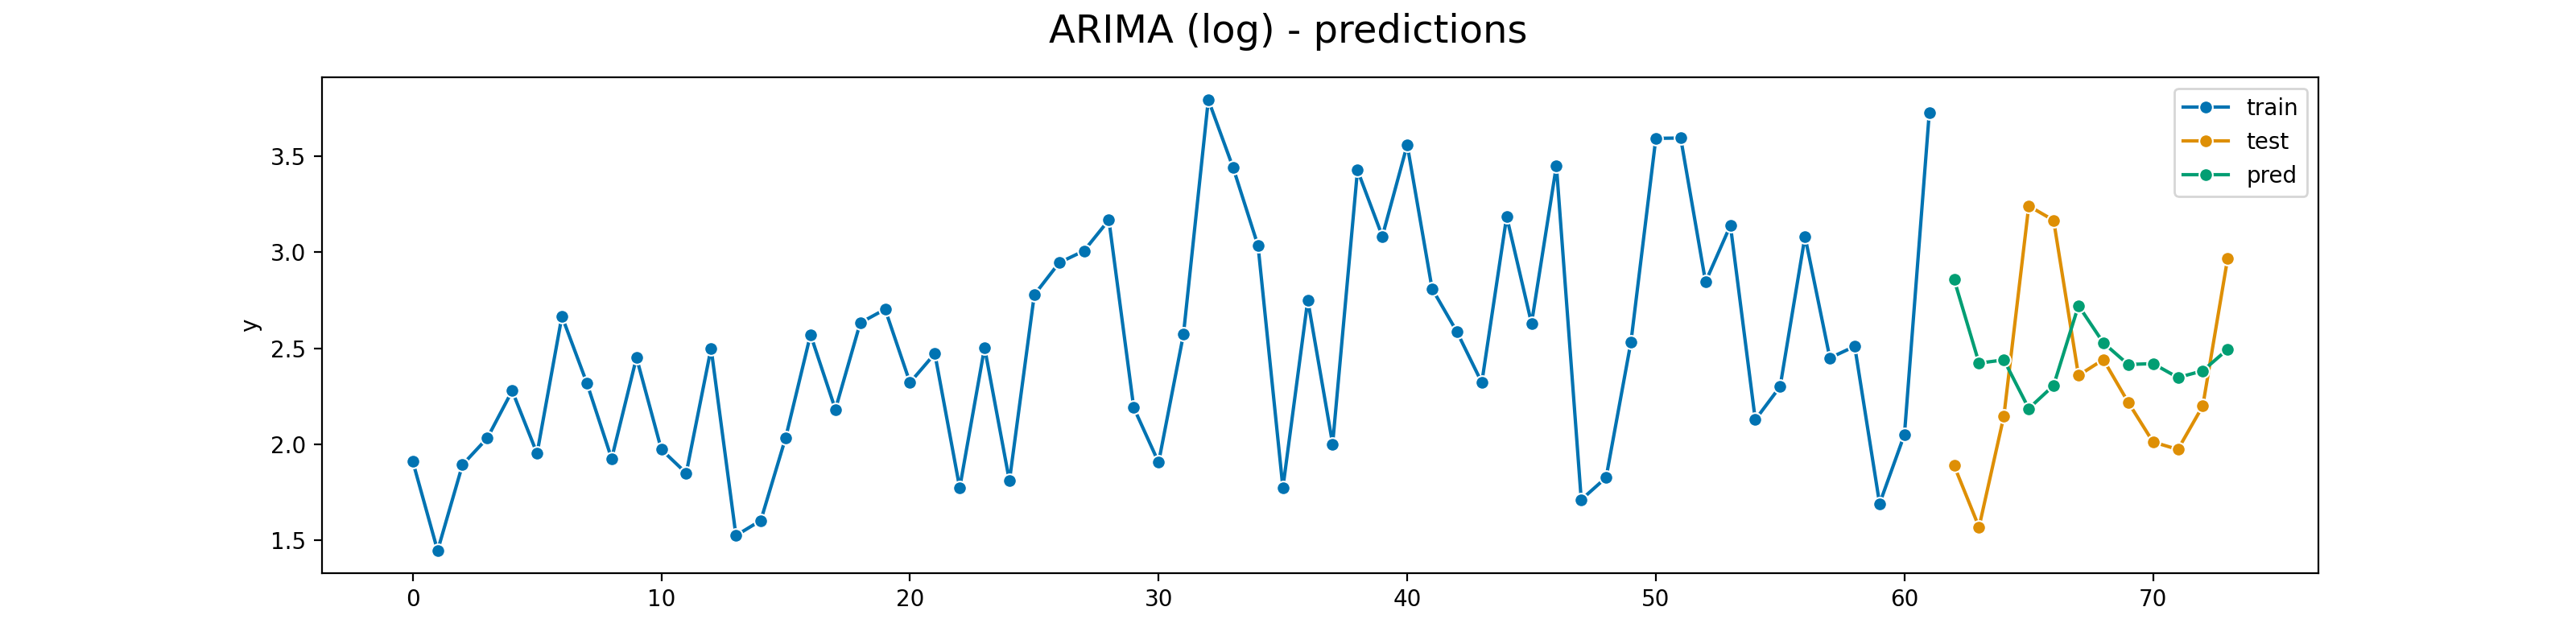

In [44]:
plot_series(y, real_values, all_models['arima_log_pipeline'].predict(fh),  labels=['train', 'test', 'pred'], title='ARIMA (log) - predictions')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

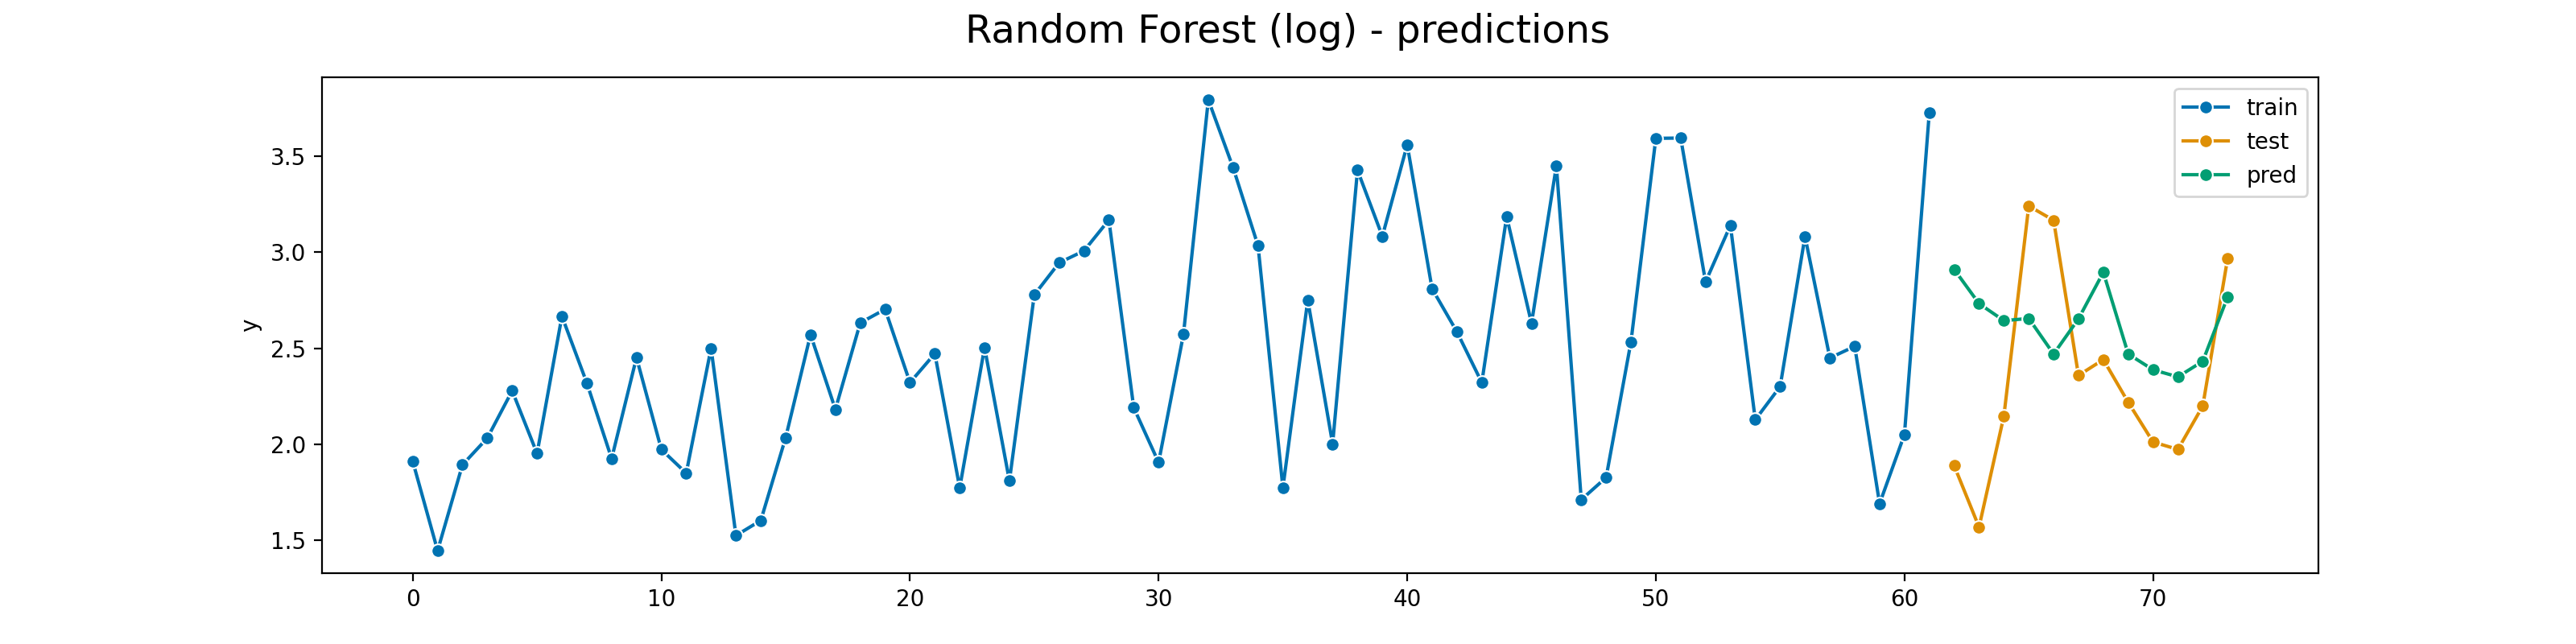

In [45]:
plot_series(y, real_values, all_models['rf_log_pipeline'].predict(fh),  labels=['train', 'test', 'pred'], title='Random Forest (log) - predictions')

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='y'>)

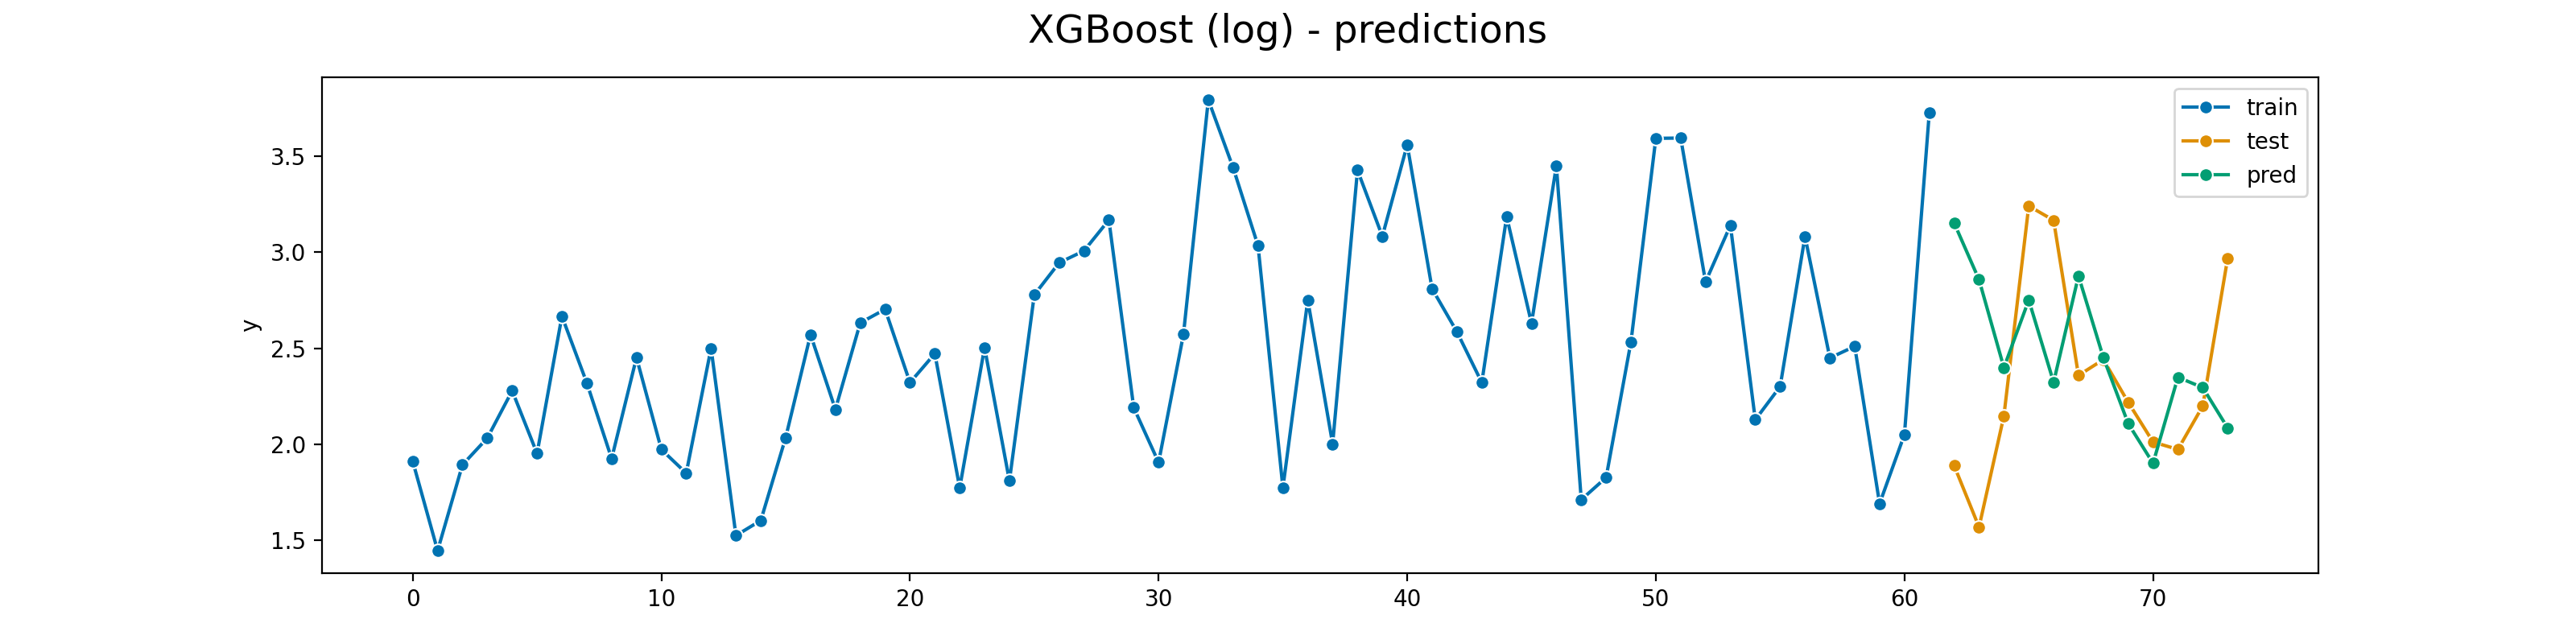

In [46]:
plot_series(y, real_values, all_models['xgboost_log_pipeline'].predict(fh),  labels=['train', 'test', 'pred'], title='XGBoost (log) - predictions')

Comentaries: 
* residuals analysis on transformers need to be done
* MAPE is around 20%
* RF why is better
* LSTM 